# 감정 인식 모델 학습 연습: Kaggle FER 2018

- Dataset: https://www.kaggle.com/datasets/ashishpatel26/fer2018/data
- https://www.kaggle.com/code/veb101/facial-expression-recognition-using-pytorch/notebook
- https://github.com/Moddy2024/ResNet-9/blob/main/resnet-9.ipynb


In [1]:
!python -V

Python 3.9.7


In [2]:
import sys

print(sys.version)

3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:53:32) [GCC 12.3.0]


In [3]:
!{sys.executable} -m pip install -q tqdm

In [4]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision.utils import make_grid
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

https://www.kaggle.com/datasets/ashishpatel26/fer2018/data


In [6]:
DATASET_HOME = "./archive"
print(f"{DATASET_HOME = }")

DATASET_PATH = os.path.join(DATASET_HOME, "fer20131.csv")
print(f"{DATASET_PATH = }")

DATASET_HOME = './archive'
DATASET_PATH = './archive/fer20131.csv'


In [7]:
dataset = pd.read_csv(DATASET_PATH)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [8]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [9]:
dataset.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

- `Traning`, `PublicTest`를 합쳐서 학습 8 : validation 2 비율로 사용.
- `PrivateTest`는 최종 테스트 데이터로 사용


In [10]:
pixels = []

for pix in tqdm(dataset.pixels, total=len(dataset.pixels)):
    values = [int(i) for i in pix.split()]
    pixels.append(values)

print(len(pixels))

100%|██████████| 35887/35887 [00:11<00:00, 3252.64it/s]

35887


In [11]:
pixels = np.array(pixels)

# 0~255로 돼있는 픽셀 값을 0~1 범위로 변경
pixels = pixels / 255.0

pixels[0]

array([0.2745098 , 0.31372549, 0.32156863, ..., 0.41568627, 0.42745098,
       0.32156863])

In [12]:
dataset.drop(columns=["pixels"], axis=1, inplace=True)
dataset

,emotion,Usage
0,0,Training
1,0,Training
2,2,Training
3,4,Training
4,6,Training
...,...,...
35882,6,PrivateTest
35883,3,PrivateTest
35884,0,PrivateTest
35885,3,PrivateTest


In [13]:
pix_cols = []

# add each pixel value as a column
for i in tqdm(range(pixels.shape[1]), total=pixels.shape[1]):
    name = f"pixel_{i}"
    pix_cols.append(name)
    dataset[name] = pixels[:, i]

100%|██████████| 2304/2304 [00:02<00:00, 1063.15it/s]


In [14]:
dataset.head()

,emotion,Usage,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,...,pixel_2294,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303
0,0,Training,0.274510,0.313725,0.321569,0.282353,0.227451,0.227451,0.235294,0.247059,...,0.623529,0.713725,0.717647,0.533333,0.415686,0.454902,0.372549,0.415686,0.427451,0.321569
1,0,Training,0.592157,0.588235,0.576471,0.607843,0.580392,0.521569,0.435294,0.549020,...,0.411765,0.423529,0.372549,0.423529,0.400000,0.262745,0.670588,0.756863,0.717647,0.721569
2,2,Training,0.905882,0.831373,0.611765,0.643137,0.682353,0.541176,0.631373,0.678431,...,0.407843,0.541176,0.596078,0.478431,0.447059,0.396078,0.380392,0.345098,0.431373,0.596078
3,4,Training,0.094118,0.125490,0.141176,0.117647,0.125490,0.090196,0.074510,0.078431,...,0.682353,0.494118,0.517647,0.517647,0.521569,0.533333,0.545098,0.556863,0.560784,0.556863
4,6,Training,0.015686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047059,0.133333,0.121569,0.121569,0.121569,0.105882,0.121569,0.117647,0.113725,0.117647


In [15]:
emotions = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral",
}

In [16]:
class FERDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.tensor_transform = T.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = int(row["emotion"])
        img = np.copy(row[pix_cols].values.reshape(48, 48))
        img.setflags(write=True)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        else:
            img = self.tensor_transform(img)

        return img, img_id

## Data Imbalance


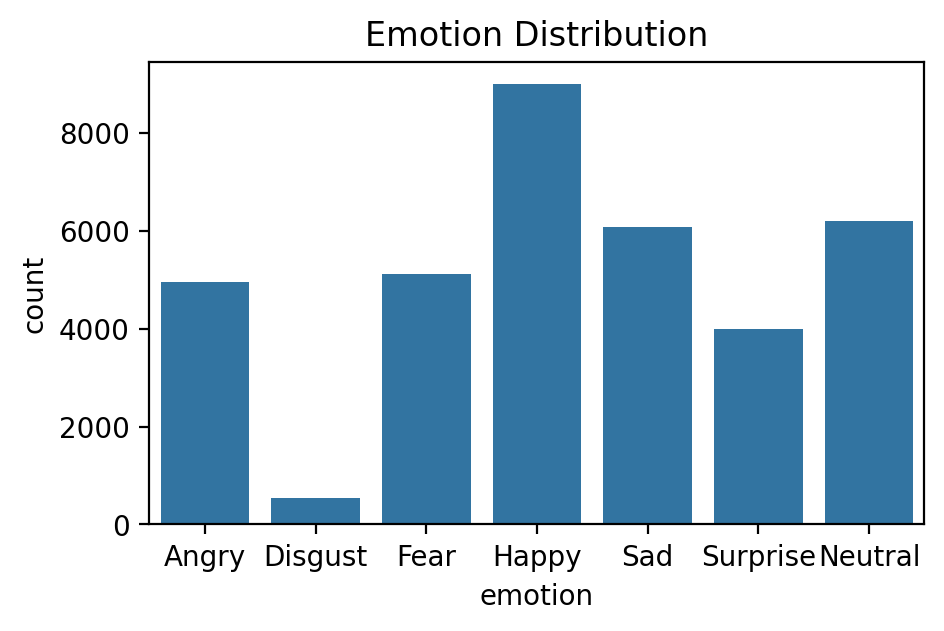

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)

sns.countplot(x=dataset.emotion, ax=ax)
ax.set_title("Emotion Distribution")
ax.set_xticks(ticks=range(0, 7), labels=emotions.values())

plt.show()
plt.close(fig)

- `Disgust`가 다른 데이터에 비해 양이 적음


In [18]:
def image_transformations() -> (object, object):
    print("image_transformations")

    train_trans = [
        T.RandomCrop(48, padding=4, padding_mode="reflect"),
        T.RandomRotation(15),
        T.RandomAffine(degrees=0, translate=(0.01, 0.12), shear=(0.01, 0.03)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
    ]

    val_trans = [
        T.ToTensor(),
    ]

    train_transformations = T.Compose(train_trans)
    valid_tfms = T.Compose(val_trans)

    return train_transformations, valid_tfms

## Dataset and Dataloader


In [19]:
def get_train_dataset(
    dataframe: object, transformation: bool = True
) -> (object, object):
    """
    Returns an object on FERDataset class
    """
    dataframe = dataframe.loc[dataframe.Usage.isin(["Training", "PublicTest"])]
    dataframe = dataframe.drop("Usage", axis=1)

    # split dataset into training and validation set
    # seed 고정을 통해 난수를 일관되게 생성. 코드를 실행할 때마다 동일한 난수 순서를 얻을 수 있음
    # => 모델 학습 및 실험의 일관성 보장!
    np.random.seed(42)
    msk = np.random.rand(len(dataframe)) < 0.8

    train_df = dataframe[msk].reset_index()
    val_df = dataframe[~msk].reset_index()

    if transformation:
        train_tfms, valid_tfms = image_transformations()
    else:
        train_tfms, valid_tfms = None, None

    train_ds = FERDataset(dataframe, transform=train_tfms)
    val_ds = FERDataset(dataframe, transform=valid_tfms)

    return train_ds, val_ds

In [20]:
def get_train_dataloader(
    dataframe: object, transformation=True, batch_size: int = 64
) -> (object, object):
    train_ds, valid_ds = get_train_dataset(dataframe, transformation=transformation)

    train_dl = DataLoader(
        train_ds, batch_size, shuffle=True, num_workers=8, pin_memory=True
    )
    valid_dl = DataLoader(valid_ds, batch_size * 2, num_workers=8, pin_memory=True)

    return train_dl, valid_dl

## Visualization


In [21]:
train_dl_un, _ = get_train_dataloader(dataset, transformation=False)
train_dl, _ = get_train_dataloader(dataset)

image_transformations


images.shape: torch.Size([64, 1, 48, 48])


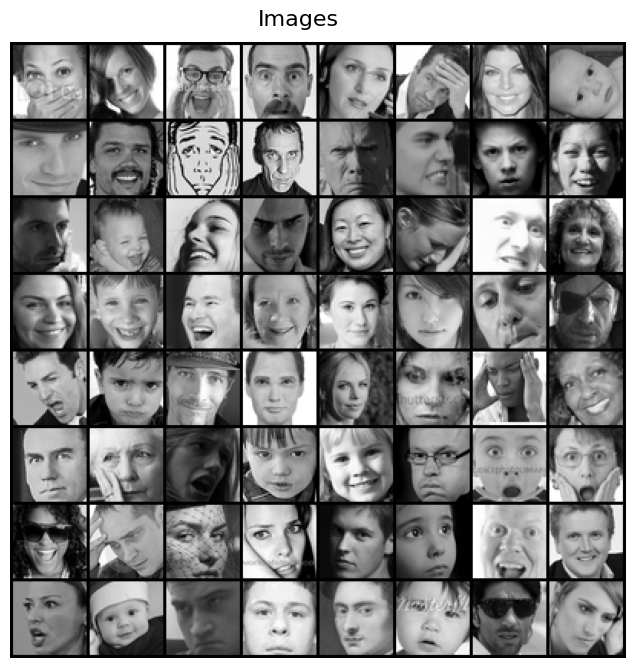

In [22]:
for images, _ in train_dl_un:
    print("images.shape:", images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

_ = plt.suptitle("Images", y=0.92, fontsize=16)

images.shape: torch.Size([64, 1, 48, 48])


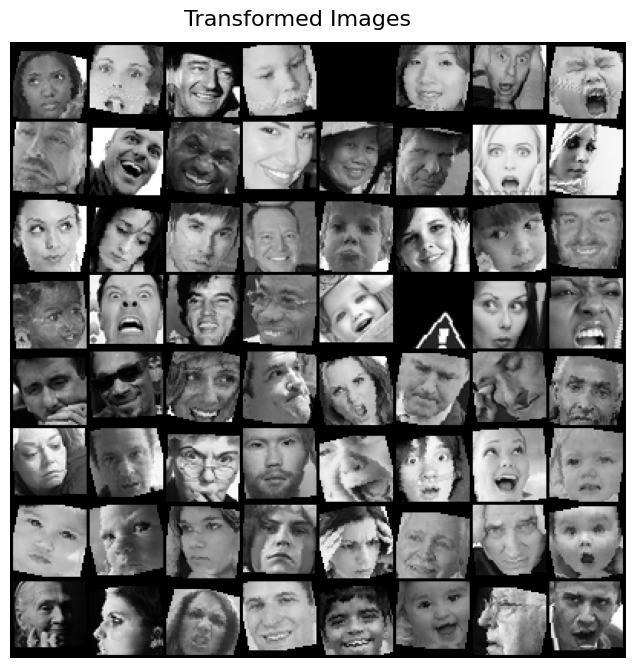

In [23]:
for images, _ in train_dl:
    print("images.shape:", images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

_ = plt.suptitle("Transformed Images", y=0.92, fontsize=16)

## Setting up GPU usage


In [24]:
def get_default_device():
    cuda = torch.cuda.is_available()
    print(f"{cuda = }")

    if cuda:
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [25]:
device = get_default_device()
device

cuda = True


device(type='cuda')

## Model Building


In [26]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {"loss": loss, "acc": acc.detach()}

    def validation_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {"val_loss": loss.detach(), "val_acc": acc.detach()}

    def get_metrics_epoch_end(self, outputs, validation=True):
        if validation:
            loss_ = "val_loss"
            acc_ = "val_acc"
        else:
            loss_ = "loss"
            acc_ = "acc"

        batch_losses = [x[f"{loss_}"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()

        batch_accs = [x[f"{acc_}"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        return {
            f"{loss_}": epoch_loss.detach().item(),
            f"{acc_}": epoch_acc.detach().item(),
        }

    def epoch_end(self, epoch, result, num_epochs):
        print(
            f"Epoch: {epoch+1}/{num_epochs} -> lr: {result['lrs'][-1]:.5f} "
            f"loss: {result['loss']:.4f}, acc: {result['acc']:.4f}, "
            f"val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}\n"
        )

### Metric


In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [28]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    ]

    if pool:
        layers.append(nn.MaxPool2d(kernel_size=2))

    return nn.Sequential(*layers)

- https://woochan-autobiography.tistory.com/884
- O = ((I - F + 2P) / S) + 1
  - Input
  - Filter(Kernel Size)
  - Padding
  - Stride


### Model: ResNet-9

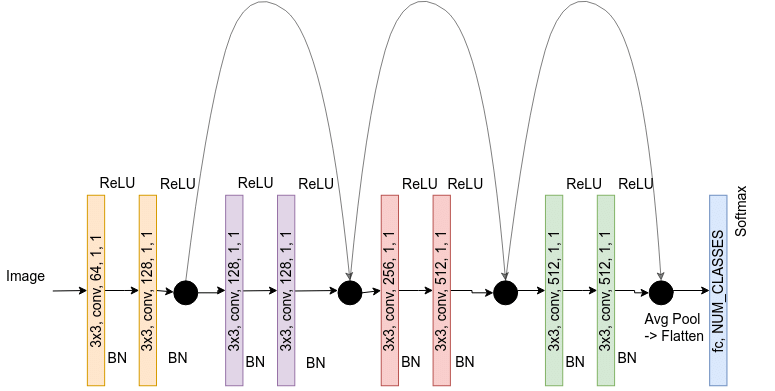

- 이 모델의 장단점?


In [29]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # 48 - 3 + 2 + 1 = 48
        self.conv1 = conv_block(in_channels, 48, pool=True)
        self.conv2 = conv_block(48, 96, pool=True)
        self.res1 = nn.Sequential(
            conv_block(96, 96, pool=False),
            conv_block(96, 96, pool=False),
        )

        self.conv3 = conv_block(96, 192, pool=True)
        self.conv4 = conv_block(192, 384, pool=True)

        self.res2 = nn.Sequential(conv_block(384, 384), conv_block(384, 384))

        self.classifier = nn.Sequential(
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(384, num_classes),
        )
        self.network = nn.Sequential(
            self.conv1,
            self.conv2,
            self.res1,
            self.conv3,
            self.conv4,
            self.res2,
            self.classifier,
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

    def __repr__(self):
        return f"{self.network}"

    def __str__(self):
        summary(self.network, (1, 48, 48))

## Setup Training


In [30]:
@torch.no_grad()
def evaluate(model: ImageClassificationBase, val_loader: object) -> dict:
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.get_metrics_epoch_end(outputs=outputs, validation=True)


def get_lr(optimizer: object) -> float:
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_model(model_name: str,
              model: object,
              epochs: int,
              max_lr: float,
              train_loader: object,
              val_loader: object,
              weight_decay: float = 0,
              grad_clip: float = None,
              opt_func: object = torch.optim.SGD):
    torch.cuda.empty_cache()
    BEST_VAL_SCORE = 0.0
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=max_lr,
        epochs=epochs,
        steps_per_epoch=len(train_loader)
    )

    for epoch in range(epochs):
        train_history = []
        lrs = []

        # Training Phase
        model.train()
        for batch in tqdm(train_loader, ascii=True, desc=f'Epoch: {epoch+1}/{epochs}'):
            info = model.training_step(batch)
            loss = info['loss']

            train_history.append(info)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            scheduler.step()

        train_result = model.get_metrics_epoch_end(
            train_history, validation=False)
        val_result = evaluate(model, val_loader)
        result = {**train_result, **val_result}
        result['lrs'] = lrs

        model.epoch_end(epoch, result, epochs)

        if result['val_acc'] > BEST_VAL_SCORE:
            BEST_VAL_SCORE = result['val_acc']
            save_name = f"{model_name}_epoch-{epoch+1}_score-{round(result['val_acc'], 4)}.pth"
            !rm -f '{model_name}'_*
            torch.save(model.state_dict(), save_name)

        history.append(result)
    return history

In [31]:
def get_test_dataloader(dataframe: object, batch_size: int = 128) -> object:
    test_df = dataframe.loc[dataset.Usage.isin(["PrivateTest"])]

    test_df = test_df.drop("Usage", axis=1)

    _, valid_tfms = image_transformations()

    test_dataset = FERDataset(test_df, transform=valid_tfms)
    test_dl = DataLoader(test_dataset, batch_size, num_workers=8, pin_memory=True)

    # move loader to GPU
    test_dl = DeviceDataLoader(test_dl, device)
    return test_dl

In [32]:
def load_best(model_name: str) -> object:
    best_model = models[model_name]

    path = "./"
    file_path = ""

    for i in os.listdir(path):
        if os.path.isfile(os.path.join(path, i)) and i.startswith(f"{model_name}"):
            file_path = os.path.join(path, i)

    print(f"Loaded model: {file_path[2:]} weights")
    best_model.load_state_dict(torch.load(file_path))

    best_model = to_device(best_model, device)
    return best_model


@torch.no_grad()
def generate_prediction(model_name: str) -> None:
    test_dl = get_test_dataloader(dataset)

    model = load_best(model_name)

    torch.cuda.empty_cache()

    with torch.no_grad():
        model.eval()
        outputs = [model.validation_step(batch) for batch in test_dl]
        metrics = model.get_metrics_epoch_end(outputs=outputs, validation=True)

    print(
        f"Test Scores:\n Loss: {round(metrics['val_loss'], 3)}, "
        f"Accuracy: {round(metrics['val_acc'], 3)}"
    )

In [33]:
def end_to_end(model_name: str, parameters: dict = None) -> dict:
    torch.cuda.empty_cache()

    train_dl, valid_dl = get_train_dataloader(
        dataset, batch_size=parameters["batch_size"]
    )

    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)

    model = models[model_name]

    model = to_device(model, device)

    # train model
    history = fit_model(
        model_name,
        model,
        parameters["epochs"],
        parameters["max_lr"],
        train_dl,
        valid_dl,
        parameters["weight_decay"],
        parameters["grad_clip"],
        parameters["opt_func"],
    )

    # cleaning
    torch.cuda.empty_cache()

    # generate predictions
    print("Genearating predictions on the Test set")
    generate_prediction(model_name)
    return history

In [34]:
def plot_accuracies(history):
    train_acc = [r['acc'] for r in history]
    val_acc = [r['val_acc'] for r in history]
    plt.plot(train_acc, '-kx', label="train_acc")
    plt.plot(val_acc, '-rx', label="val_acc")
    plt.legend()
    _ = plt.xticks(ticks=range(len(train_acc)),
                   labels=[str(i) for i in range(1, len(train_acc)+1)])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. epochs')


def plot_losses(history):
    train_losses = [r['loss'] for r in history]
    val_losses = [r['val_loss'] for r in history]
    plt.plot(train_losses, '-kx', label="train_loss")
    plt.plot(val_losses, '-rx', label="val_loss")
    plt.legend()
    _ = plt.xticks(ticks=range(len(train_losses)),
                   labels=[str(i) for i in range(1, len(train_losses)+1)])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. epochs')


def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

### Models


In [35]:
models = {
    "ResNet9": ResNet9(in_channels=1, num_classes=7),
}

In [36]:
models["ResNet9"].__str__()

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 48, 24, 24]          --
|    └─Conv2d: 2-1                       [-1, 48, 48, 48]          480
|    └─BatchNorm2d: 2-2                  [-1, 48, 48, 48]          96
|    └─ReLU: 2-3                         [-1, 48, 48, 48]          --
|    └─MaxPool2d: 2-4                    [-1, 48, 24, 24]          --
├─Sequential: 1-2                        [-1, 96, 12, 12]          --
|    └─Conv2d: 2-5                       [-1, 96, 24, 24]          41,568
|    └─BatchNorm2d: 2-6                  [-1, 96, 24, 24]          192
|    └─ReLU: 2-7                         [-1, 96, 24, 24]          --
|    └─MaxPool2d: 2-8                    [-1, 96, 12, 12]          --
├─Sequential: 1-3                        [-1, 96, 12, 12]          --
|    └─Sequential: 2-9                   [-1, 96, 12, 12]          --
|    |    └─Conv2d: 3-1                  [-1, 96, 12, 12]          83,040
|    

### Train Model


In [37]:
training_parameters = {
    "batch_size": 512,
    "epochs": 200,
    "max_lr": 0.01,
    "weight_decay": 0.0001,
    "grad_clip": 0.1,
    "opt_func": torch.optim.Adam,
}

In [38]:
model_name = "ResNet9"

history = end_to_end(model_name, training_parameters)

image_transformations


Epoch: 1/200: 100%|##########| 64/64 [00:18<00:00,  3.51it/s]


Epoch: 1/200 -> lr: 0.00041 loss: 1.9711, acc: 0.2519, val_loss: 1.6457, val_acc: 0.3577



Epoch: 2/200: 100%|##########| 64/64 [00:18<00:00,  3.52it/s]


Epoch: 2/200 -> lr: 0.00043 loss: 1.6914, acc: 0.3470, val_loss: 1.5322, val_acc: 0.4099



Epoch: 3/200: 100%|##########| 64/64 [00:18<00:00,  3.50it/s]


Epoch: 3/200 -> lr: 0.00046 loss: 1.5458, acc: 0.4085, val_loss: 1.3499, val_acc: 0.4838



Epoch: 4/200: 100%|##########| 64/64 [00:18<00:00,  3.40it/s]


Epoch: 4/200 -> lr: 0.00050 loss: 1.4376, acc: 0.4536, val_loss: 1.2714, val_acc: 0.5118



Epoch: 5/200: 100%|##########| 64/64 [00:18<00:00,  3.39it/s]


Epoch: 5/200 -> lr: 0.00056 loss: 1.3482, acc: 0.4869, val_loss: 1.4205, val_acc: 0.4529



Epoch: 6/200: 100%|##########| 64/64 [00:18<00:00,  3.40it/s]


Epoch: 6/200 -> lr: 0.00063 loss: 1.2893, acc: 0.5097, val_loss: 1.1854, val_acc: 0.5508



Epoch: 7/200: 100%|##########| 64/64 [00:18<00:00,  3.41it/s]


Epoch: 7/200 -> lr: 0.00072 loss: 1.2507, acc: 0.5250, val_loss: 1.1180, val_acc: 0.5780



Epoch: 8/200: 100%|##########| 64/64 [00:18<00:00,  3.47it/s]


Epoch: 8/200 -> lr: 0.00081 loss: 1.2279, acc: 0.5315, val_loss: 1.1288, val_acc: 0.5758



Epoch: 9/200: 100%|##########| 64/64 [00:18<00:00,  3.44it/s]


Epoch: 9/200 -> lr: 0.00092 loss: 1.1933, acc: 0.5489, val_loss: 1.2062, val_acc: 0.5574



Epoch: 10/200: 100%|##########| 64/64 [00:18<00:00,  3.37it/s]


Epoch: 10/200 -> lr: 0.00104 loss: 1.1671, acc: 0.5589, val_loss: 1.1095, val_acc: 0.5752



Epoch: 11/200: 100%|##########| 64/64 [00:18<00:00,  3.51it/s]


Epoch: 11/200 -> lr: 0.00117 loss: 1.1396, acc: 0.5646, val_loss: 1.0936, val_acc: 0.5873



Epoch: 12/200: 100%|##########| 64/64 [00:18<00:00,  3.41it/s]


Epoch: 12/200 -> lr: 0.00131 loss: 1.1276, acc: 0.5722, val_loss: 1.1112, val_acc: 0.5704



Epoch: 13/200: 100%|##########| 64/64 [00:18<00:00,  3.43it/s]


Epoch: 13/200 -> lr: 0.00147 loss: 1.1100, acc: 0.5802, val_loss: 1.1954, val_acc: 0.5477



Epoch: 14/200: 100%|##########| 64/64 [00:18<00:00,  3.37it/s]


Epoch: 14/200 -> lr: 0.00163 loss: 1.0916, acc: 0.5855, val_loss: 2.1133, val_acc: 0.3529



Epoch: 15/200: 100%|##########| 64/64 [00:19<00:00,  3.32it/s]


Epoch: 15/200 -> lr: 0.00180 loss: 1.0872, acc: 0.5872, val_loss: 1.0884, val_acc: 0.5985



Epoch: 16/200: 100%|##########| 64/64 [00:18<00:00,  3.50it/s]


Epoch: 16/200 -> lr: 0.00199 loss: 1.0860, acc: 0.5867, val_loss: 0.9816, val_acc: 0.6294



Epoch: 17/200: 100%|##########| 64/64 [00:19<00:00,  3.35it/s]


Epoch: 17/200 -> lr: 0.00218 loss: 1.0808, acc: 0.5900, val_loss: 1.0780, val_acc: 0.5838



Epoch: 18/200: 100%|##########| 64/64 [00:18<00:00,  3.42it/s]


Epoch: 18/200 -> lr: 0.00238 loss: 1.0689, acc: 0.5927, val_loss: 1.2353, val_acc: 0.5370



Epoch: 19/200: 100%|##########| 64/64 [00:19<00:00,  3.32it/s]


Epoch: 19/200 -> lr: 0.00258 loss: 1.0640, acc: 0.5998, val_loss: 1.0717, val_acc: 0.5943



Epoch: 20/200: 100%|##########| 64/64 [00:18<00:00,  3.46it/s]


Epoch: 20/200 -> lr: 0.00280 loss: 1.0628, acc: 0.5990, val_loss: 1.2033, val_acc: 0.5662



Epoch: 21/200: 100%|##########| 64/64 [00:18<00:00,  3.40it/s]


Epoch: 21/200 -> lr: 0.00302 loss: 1.0499, acc: 0.6068, val_loss: 1.0214, val_acc: 0.6061



Epoch: 22/200: 100%|##########| 64/64 [00:18<00:00,  3.44it/s]


Epoch: 22/200 -> lr: 0.00325 loss: 1.0474, acc: 0.6053, val_loss: 1.2682, val_acc: 0.5369



Epoch: 23/200: 100%|##########| 64/64 [00:18<00:00,  3.51it/s]


Epoch: 23/200 -> lr: 0.00348 loss: 1.0435, acc: 0.6085, val_loss: 1.0470, val_acc: 0.6066



Epoch: 24/200: 100%|##########| 64/64 [00:19<00:00,  3.29it/s]


Epoch: 24/200 -> lr: 0.00371 loss: 1.0246, acc: 0.6132, val_loss: 1.1824, val_acc: 0.5347



Epoch: 25/200: 100%|##########| 64/64 [00:18<00:00,  3.44it/s]


Epoch: 25/200 -> lr: 0.00396 loss: 1.0268, acc: 0.6103, val_loss: 1.0252, val_acc: 0.6189



Epoch: 26/200: 100%|##########| 64/64 [00:18<00:00,  3.41it/s]


Epoch: 26/200 -> lr: 0.00420 loss: 1.0029, acc: 0.6221, val_loss: 1.2027, val_acc: 0.5424



Epoch: 27/200: 100%|##########| 64/64 [00:18<00:00,  3.39it/s]


Epoch: 27/200 -> lr: 0.00445 loss: 1.0125, acc: 0.6159, val_loss: 0.9458, val_acc: 0.6400



Epoch: 28/200: 100%|##########| 64/64 [00:19<00:00,  3.31it/s]


Epoch: 28/200 -> lr: 0.00470 loss: 0.9956, acc: 0.6267, val_loss: 1.1479, val_acc: 0.5675



Epoch: 29/200: 100%|##########| 64/64 [00:18<00:00,  3.39it/s]


Epoch: 29/200 -> lr: 0.00495 loss: 0.9974, acc: 0.6236, val_loss: 1.0122, val_acc: 0.6177



Epoch: 30/200: 100%|##########| 64/64 [00:18<00:00,  3.37it/s]


Epoch: 30/200 -> lr: 0.00520 loss: 0.9820, acc: 0.6289, val_loss: 1.0126, val_acc: 0.6212



Epoch: 31/200: 100%|##########| 64/64 [00:19<00:00,  3.26it/s]


Epoch: 31/200 -> lr: 0.00545 loss: 0.9801, acc: 0.6333, val_loss: 1.1618, val_acc: 0.5683



Epoch: 32/200: 100%|##########| 64/64 [00:18<00:00,  3.53it/s]


Epoch: 32/200 -> lr: 0.00570 loss: 0.9722, acc: 0.6324, val_loss: 1.0147, val_acc: 0.6185



Epoch: 33/200: 100%|##########| 64/64 [00:18<00:00,  3.51it/s]


Epoch: 33/200 -> lr: 0.00595 loss: 0.9723, acc: 0.6377, val_loss: 0.9232, val_acc: 0.6475



Epoch: 34/200: 100%|##########| 64/64 [00:18<00:00,  3.43it/s]


Epoch: 34/200 -> lr: 0.00620 loss: 0.9615, acc: 0.6387, val_loss: 1.2203, val_acc: 0.5788



Epoch: 35/200: 100%|##########| 64/64 [00:18<00:00,  3.48it/s]


Epoch: 35/200 -> lr: 0.00644 loss: 0.9788, acc: 0.6333, val_loss: 0.9822, val_acc: 0.6159



Epoch: 36/200: 100%|##########| 64/64 [00:19<00:00,  3.22it/s]


Epoch: 36/200 -> lr: 0.00668 loss: 0.9639, acc: 0.6343, val_loss: 0.9841, val_acc: 0.6298



Epoch: 37/200: 100%|##########| 64/64 [00:19<00:00,  3.32it/s]


Epoch: 37/200 -> lr: 0.00692 loss: 0.9607, acc: 0.6383, val_loss: 1.0979, val_acc: 0.5780



Epoch: 38/200: 100%|##########| 64/64 [00:18<00:00,  3.40it/s]


Epoch: 38/200 -> lr: 0.00715 loss: 0.9670, acc: 0.6374, val_loss: 0.9529, val_acc: 0.6374



Epoch: 39/200: 100%|##########| 64/64 [00:19<00:00,  3.36it/s]


Epoch: 39/200 -> lr: 0.00738 loss: 0.9629, acc: 0.6386, val_loss: 1.1376, val_acc: 0.5732



Epoch: 40/200: 100%|##########| 64/64 [00:19<00:00,  3.26it/s]


Epoch: 40/200 -> lr: 0.00760 loss: 0.9636, acc: 0.6390, val_loss: 1.1963, val_acc: 0.5663



Epoch: 41/200: 100%|##########| 64/64 [00:18<00:00,  3.44it/s]


Epoch: 41/200 -> lr: 0.00781 loss: 0.9643, acc: 0.6396, val_loss: 1.0611, val_acc: 0.5931



Epoch: 42/200: 100%|##########| 64/64 [00:18<00:00,  3.43it/s]


Epoch: 42/200 -> lr: 0.00802 loss: 0.9575, acc: 0.6391, val_loss: 0.9754, val_acc: 0.6339



Epoch: 43/200: 100%|##########| 64/64 [00:18<00:00,  3.40it/s]


Epoch: 43/200 -> lr: 0.00822 loss: 0.9570, acc: 0.6409, val_loss: 1.1293, val_acc: 0.5844



Epoch: 44/200: 100%|##########| 64/64 [00:18<00:00,  3.40it/s]


Epoch: 44/200 -> lr: 0.00841 loss: 0.9774, acc: 0.6332, val_loss: 1.0189, val_acc: 0.6170



Epoch: 45/200: 100%|##########| 64/64 [00:19<00:00,  3.29it/s]


Epoch: 45/200 -> lr: 0.00859 loss: 0.9609, acc: 0.6379, val_loss: 1.7221, val_acc: 0.4216



Epoch: 46/200: 100%|##########| 64/64 [00:19<00:00,  3.30it/s]


Epoch: 46/200 -> lr: 0.00877 loss: 0.9770, acc: 0.6338, val_loss: 0.9622, val_acc: 0.6311



Epoch: 47/200: 100%|##########| 64/64 [00:19<00:00,  3.21it/s]


Epoch: 47/200 -> lr: 0.00893 loss: 0.9684, acc: 0.6373, val_loss: 1.1005, val_acc: 0.5870



Epoch: 48/200: 100%|##########| 64/64 [00:19<00:00,  3.25it/s]


Epoch: 48/200 -> lr: 0.00908 loss: 0.9610, acc: 0.6401, val_loss: 1.0653, val_acc: 0.5987



Epoch: 49/200: 100%|##########| 64/64 [00:19<00:00,  3.22it/s]


Epoch: 49/200 -> lr: 0.00923 loss: 0.9634, acc: 0.6420, val_loss: 1.1483, val_acc: 0.5517



Epoch: 50/200: 100%|##########| 64/64 [00:20<00:00,  3.18it/s]


Epoch: 50/200 -> lr: 0.00936 loss: 0.9728, acc: 0.6341, val_loss: 1.0061, val_acc: 0.6230



Epoch: 51/200: 100%|##########| 64/64 [00:20<00:00,  3.17it/s]


Epoch: 51/200 -> lr: 0.00948 loss: 0.9702, acc: 0.6332, val_loss: 1.0203, val_acc: 0.6162



Epoch: 52/200: 100%|##########| 64/64 [00:18<00:00,  3.47it/s]


Epoch: 52/200 -> lr: 0.00958 loss: 0.9756, acc: 0.6367, val_loss: 1.3825, val_acc: 0.4756



Epoch: 53/200: 100%|##########| 64/64 [00:20<00:00,  3.15it/s]


Epoch: 53/200 -> lr: 0.00968 loss: 0.9900, acc: 0.6277, val_loss: 1.1694, val_acc: 0.5488



Epoch: 54/200: 100%|##########| 64/64 [00:20<00:00,  3.12it/s]


Epoch: 54/200 -> lr: 0.00976 loss: 0.9659, acc: 0.6340, val_loss: 1.0777, val_acc: 0.5983



Epoch: 55/200: 100%|##########| 64/64 [00:19<00:00,  3.29it/s]


Epoch: 55/200 -> lr: 0.00984 loss: 0.9761, acc: 0.6344, val_loss: 1.0540, val_acc: 0.5922



Epoch: 56/200: 100%|##########| 64/64 [00:20<00:00,  3.16it/s]


Epoch: 56/200 -> lr: 0.00990 loss: 0.9727, acc: 0.6328, val_loss: 1.0698, val_acc: 0.5985



Epoch: 57/200: 100%|##########| 64/64 [00:20<00:00,  3.15it/s]


Epoch: 57/200 -> lr: 0.00994 loss: 0.9784, acc: 0.6312, val_loss: 1.1657, val_acc: 0.5530



Epoch: 58/200: 100%|##########| 64/64 [00:19<00:00,  3.26it/s]


Epoch: 58/200 -> lr: 0.00997 loss: 0.9933, acc: 0.6244, val_loss: 1.6695, val_acc: 0.3767



Epoch: 59/200: 100%|##########| 64/64 [00:20<00:00,  3.18it/s]


Epoch: 59/200 -> lr: 0.00999 loss: 0.9940, acc: 0.6263, val_loss: 1.3791, val_acc: 0.4474



Epoch: 60/200: 100%|##########| 64/64 [00:19<00:00,  3.22it/s]


Epoch: 60/200 -> lr: 0.01000 loss: 0.9895, acc: 0.6273, val_loss: 1.4203, val_acc: 0.4717



Epoch: 61/200: 100%|##########| 64/64 [00:18<00:00,  3.41it/s]


Epoch: 61/200 -> lr: 0.01000 loss: 0.9832, acc: 0.6312, val_loss: 1.7451, val_acc: 0.3910



Epoch: 62/200: 100%|##########| 64/64 [00:19<00:00,  3.20it/s]


Epoch: 62/200 -> lr: 0.00999 loss: 0.9886, acc: 0.6292, val_loss: 1.1232, val_acc: 0.5754



Epoch: 63/200: 100%|##########| 64/64 [00:18<00:00,  3.38it/s]


Epoch: 63/200 -> lr: 0.00999 loss: 0.9886, acc: 0.6307, val_loss: 1.2729, val_acc: 0.5043



Epoch: 64/200: 100%|##########| 64/64 [00:19<00:00,  3.28it/s]


Epoch: 64/200 -> lr: 0.00998 loss: 0.9840, acc: 0.6288, val_loss: 1.1414, val_acc: 0.5769



Epoch: 65/200: 100%|##########| 64/64 [00:19<00:00,  3.25it/s]


Epoch: 65/200 -> lr: 0.00997 loss: 0.9835, acc: 0.6297, val_loss: 1.5374, val_acc: 0.4616



Epoch: 66/200: 100%|##########| 64/64 [00:18<00:00,  3.43it/s]


Epoch: 66/200 -> lr: 0.00995 loss: 0.9842, acc: 0.6332, val_loss: 0.9291, val_acc: 0.6470



Epoch: 67/200: 100%|##########| 64/64 [00:19<00:00,  3.34it/s]


Epoch: 67/200 -> lr: 0.00994 loss: 0.9807, acc: 0.6311, val_loss: 1.0304, val_acc: 0.6019



Epoch: 68/200: 100%|##########| 64/64 [00:19<00:00,  3.20it/s]


Epoch: 68/200 -> lr: 0.00992 loss: 0.9795, acc: 0.6303, val_loss: 1.2845, val_acc: 0.4987



Epoch: 69/200: 100%|##########| 64/64 [00:19<00:00,  3.24it/s]


Epoch: 69/200 -> lr: 0.00990 loss: 1.0144, acc: 0.6178, val_loss: 0.9944, val_acc: 0.6287



Epoch: 70/200: 100%|##########| 64/64 [00:19<00:00,  3.23it/s]


Epoch: 70/200 -> lr: 0.00987 loss: 0.9939, acc: 0.6228, val_loss: 1.0078, val_acc: 0.6194



Epoch: 71/200: 100%|##########| 64/64 [00:19<00:00,  3.28it/s]


Epoch: 71/200 -> lr: 0.00985 loss: 0.9857, acc: 0.6291, val_loss: 1.0304, val_acc: 0.6085



Epoch: 72/200: 100%|##########| 64/64 [00:18<00:00,  3.49it/s]


Epoch: 72/200 -> lr: 0.00982 loss: 0.9894, acc: 0.6307, val_loss: 1.2420, val_acc: 0.5501



Epoch: 73/200: 100%|##########| 64/64 [00:18<00:00,  3.37it/s]


Epoch: 73/200 -> lr: 0.00979 loss: 0.9869, acc: 0.6282, val_loss: 1.4709, val_acc: 0.4364



Epoch: 74/200: 100%|##########| 64/64 [00:18<00:00,  3.38it/s]


Epoch: 74/200 -> lr: 0.00976 loss: 0.9882, acc: 0.6296, val_loss: 1.0206, val_acc: 0.6192



Epoch: 75/200: 100%|##########| 64/64 [00:19<00:00,  3.36it/s]


Epoch: 75/200 -> lr: 0.00972 loss: 0.9833, acc: 0.6335, val_loss: 1.2129, val_acc: 0.5484



Epoch: 76/200: 100%|##########| 64/64 [00:18<00:00,  3.40it/s]


Epoch: 76/200 -> lr: 0.00968 loss: 1.0025, acc: 0.6227, val_loss: 1.0008, val_acc: 0.6210



Epoch: 77/200: 100%|##########| 64/64 [00:18<00:00,  3.38it/s]


Epoch: 77/200 -> lr: 0.00964 loss: 0.9911, acc: 0.6276, val_loss: 1.1865, val_acc: 0.5681



Epoch: 78/200: 100%|##########| 64/64 [00:18<00:00,  3.50it/s]


Epoch: 78/200 -> lr: 0.00960 loss: 1.0000, acc: 0.6245, val_loss: 1.0148, val_acc: 0.6128



Epoch: 79/200: 100%|##########| 64/64 [00:19<00:00,  3.31it/s]


Epoch: 79/200 -> lr: 0.00955 loss: 0.9799, acc: 0.6326, val_loss: 1.2847, val_acc: 0.5082



Epoch: 80/200: 100%|##########| 64/64 [00:19<00:00,  3.25it/s]


Epoch: 80/200 -> lr: 0.00950 loss: 0.9972, acc: 0.6250, val_loss: 1.1346, val_acc: 0.5631



Epoch: 81/200: 100%|##########| 64/64 [00:18<00:00,  3.48it/s]


Epoch: 81/200 -> lr: 0.00946 loss: 0.9951, acc: 0.6281, val_loss: 1.0161, val_acc: 0.6213



Epoch: 82/200: 100%|##########| 64/64 [00:19<00:00,  3.35it/s]


Epoch: 82/200 -> lr: 0.00940 loss: 0.9965, acc: 0.6281, val_loss: 1.0928, val_acc: 0.5843



Epoch: 83/200: 100%|##########| 64/64 [00:18<00:00,  3.49it/s]


Epoch: 83/200 -> lr: 0.00935 loss: 0.9968, acc: 0.6238, val_loss: 1.0023, val_acc: 0.6220



Epoch: 84/200: 100%|##########| 64/64 [00:18<00:00,  3.42it/s]


Epoch: 84/200 -> lr: 0.00929 loss: 0.9894, acc: 0.6266, val_loss: 1.0279, val_acc: 0.6077



Epoch: 85/200: 100%|##########| 64/64 [00:19<00:00,  3.34it/s]


Epoch: 85/200 -> lr: 0.00923 loss: 0.9964, acc: 0.6233, val_loss: 1.1594, val_acc: 0.5614



Epoch: 86/200: 100%|##########| 64/64 [00:19<00:00,  3.32it/s]


Epoch: 86/200 -> lr: 0.00917 loss: 0.9919, acc: 0.6270, val_loss: 1.0692, val_acc: 0.5802



Epoch: 87/200: 100%|##########| 64/64 [00:19<00:00,  3.36it/s]


Epoch: 87/200 -> lr: 0.00911 loss: 0.9844, acc: 0.6280, val_loss: 0.9846, val_acc: 0.6255



Epoch: 88/200: 100%|##########| 64/64 [00:18<00:00,  3.46it/s]


Epoch: 88/200 -> lr: 0.00905 loss: 0.9813, acc: 0.6303, val_loss: 1.2624, val_acc: 0.5231



Epoch: 89/200: 100%|##########| 64/64 [00:19<00:00,  3.35it/s]


Epoch: 89/200 -> lr: 0.00898 loss: 0.9828, acc: 0.6283, val_loss: 1.0427, val_acc: 0.6072



Epoch: 90/200: 100%|##########| 64/64 [00:19<00:00,  3.34it/s]


Epoch: 90/200 -> lr: 0.00891 loss: 0.9876, acc: 0.6307, val_loss: 1.1599, val_acc: 0.5474



Epoch: 91/200: 100%|##########| 64/64 [00:19<00:00,  3.25it/s]


Epoch: 91/200 -> lr: 0.00884 loss: 0.9967, acc: 0.6237, val_loss: 1.0461, val_acc: 0.6012



Epoch: 92/200: 100%|##########| 64/64 [00:19<00:00,  3.36it/s]


Epoch: 92/200 -> lr: 0.00877 loss: 0.9912, acc: 0.6314, val_loss: 1.0121, val_acc: 0.6116



Epoch: 93/200: 100%|##########| 64/64 [00:19<00:00,  3.31it/s]


Epoch: 93/200 -> lr: 0.00869 loss: 0.9813, acc: 0.6342, val_loss: 1.1067, val_acc: 0.5845



Epoch: 94/200: 100%|##########| 64/64 [00:19<00:00,  3.30it/s]


Epoch: 94/200 -> lr: 0.00861 loss: 0.9809, acc: 0.6302, val_loss: 1.0784, val_acc: 0.5934



Epoch: 95/200: 100%|##########| 64/64 [00:18<00:00,  3.42it/s]


Epoch: 95/200 -> lr: 0.00854 loss: 0.9836, acc: 0.6301, val_loss: 0.9855, val_acc: 0.6329



Epoch: 96/200: 100%|##########| 64/64 [00:19<00:00,  3.34it/s]


Epoch: 96/200 -> lr: 0.00846 loss: 0.9867, acc: 0.6296, val_loss: 1.2364, val_acc: 0.5381



Epoch: 97/200: 100%|##########| 64/64 [00:19<00:00,  3.28it/s]


Epoch: 97/200 -> lr: 0.00837 loss: 0.9900, acc: 0.6268, val_loss: 1.2112, val_acc: 0.5719



Epoch: 98/200: 100%|##########| 64/64 [00:20<00:00,  3.19it/s]


Epoch: 98/200 -> lr: 0.00829 loss: 0.9774, acc: 0.6313, val_loss: 0.9375, val_acc: 0.6448



Epoch: 99/200: 100%|##########| 64/64 [00:20<00:00,  3.18it/s]


Epoch: 99/200 -> lr: 0.00820 loss: 0.9789, acc: 0.6311, val_loss: 1.0182, val_acc: 0.6095



Epoch: 100/200: 100%|##########| 64/64 [00:19<00:00,  3.35it/s]


Epoch: 100/200 -> lr: 0.00812 loss: 0.9696, acc: 0.6333, val_loss: 0.9700, val_acc: 0.6335



Epoch: 101/200: 100%|##########| 64/64 [00:19<00:00,  3.36it/s]


Epoch: 101/200 -> lr: 0.00803 loss: 0.9714, acc: 0.6319, val_loss: 0.9159, val_acc: 0.6546



Epoch: 102/200: 100%|##########| 64/64 [00:19<00:00,  3.30it/s]


Epoch: 102/200 -> lr: 0.00794 loss: 0.9664, acc: 0.6341, val_loss: 0.9404, val_acc: 0.6446



Epoch: 103/200: 100%|##########| 64/64 [00:19<00:00,  3.29it/s]


Epoch: 103/200 -> lr: 0.00785 loss: 0.9693, acc: 0.6362, val_loss: 0.9639, val_acc: 0.6339



Epoch: 104/200: 100%|##########| 64/64 [00:19<00:00,  3.31it/s]


Epoch: 104/200 -> lr: 0.00775 loss: 0.9660, acc: 0.6370, val_loss: 0.9946, val_acc: 0.6224



Epoch: 105/200: 100%|##########| 64/64 [00:19<00:00,  3.36it/s]


Epoch: 105/200 -> lr: 0.00766 loss: 0.9531, acc: 0.6425, val_loss: 0.9463, val_acc: 0.6394



Epoch: 106/200: 100%|##########| 64/64 [00:18<00:00,  3.40it/s]


Epoch: 106/200 -> lr: 0.00756 loss: 0.9536, acc: 0.6388, val_loss: 1.1313, val_acc: 0.5630



Epoch: 107/200: 100%|##########| 64/64 [00:19<00:00,  3.29it/s]


Epoch: 107/200 -> lr: 0.00747 loss: 0.9663, acc: 0.6368, val_loss: 0.9200, val_acc: 0.6521



Epoch: 108/200: 100%|##########| 64/64 [00:19<00:00,  3.29it/s]


Epoch: 108/200 -> lr: 0.00737 loss: 0.9530, acc: 0.6416, val_loss: 1.0989, val_acc: 0.5926



Epoch: 109/200: 100%|##########| 64/64 [00:19<00:00,  3.23it/s]


Epoch: 109/200 -> lr: 0.00727 loss: 0.9568, acc: 0.6438, val_loss: 0.9666, val_acc: 0.6288



Epoch: 110/200: 100%|##########| 64/64 [00:19<00:00,  3.33it/s]


Epoch: 110/200 -> lr: 0.00717 loss: 0.9581, acc: 0.6431, val_loss: 0.9432, val_acc: 0.6375



Epoch: 111/200: 100%|##########| 64/64 [00:19<00:00,  3.31it/s]


Epoch: 111/200 -> lr: 0.00707 loss: 0.9662, acc: 0.6356, val_loss: 0.9859, val_acc: 0.6278



Epoch: 112/200: 100%|##########| 64/64 [00:19<00:00,  3.35it/s]


Epoch: 112/200 -> lr: 0.00697 loss: 0.9496, acc: 0.6399, val_loss: 0.9452, val_acc: 0.6506



Epoch: 113/200: 100%|##########| 64/64 [00:19<00:00,  3.31it/s]


Epoch: 113/200 -> lr: 0.00686 loss: 0.9387, acc: 0.6449, val_loss: 0.9434, val_acc: 0.6449



Epoch: 114/200: 100%|##########| 64/64 [00:18<00:00,  3.41it/s]


Epoch: 114/200 -> lr: 0.00676 loss: 0.9498, acc: 0.6418, val_loss: 1.0464, val_acc: 0.6169



Epoch: 115/200: 100%|##########| 64/64 [00:18<00:00,  3.38it/s]


Epoch: 115/200 -> lr: 0.00665 loss: 0.9431, acc: 0.6466, val_loss: 0.9628, val_acc: 0.6397



Epoch: 116/200: 100%|##########| 64/64 [00:19<00:00,  3.28it/s]


Epoch: 116/200 -> lr: 0.00655 loss: 0.9319, acc: 0.6494, val_loss: 0.8734, val_acc: 0.6693



Epoch: 117/200: 100%|##########| 64/64 [00:18<00:00,  3.37it/s]


Epoch: 117/200 -> lr: 0.00644 loss: 0.9387, acc: 0.6467, val_loss: 1.1729, val_acc: 0.5392



Epoch: 118/200: 100%|##########| 64/64 [00:19<00:00,  3.31it/s]


Epoch: 118/200 -> lr: 0.00633 loss: 0.9475, acc: 0.6429, val_loss: 0.9456, val_acc: 0.6415



Epoch: 119/200: 100%|##########| 64/64 [00:20<00:00,  3.19it/s]


Epoch: 119/200 -> lr: 0.00622 loss: 0.9205, acc: 0.6521, val_loss: 0.8738, val_acc: 0.6721



Epoch: 120/200: 100%|##########| 64/64 [00:19<00:00,  3.32it/s]


Epoch: 120/200 -> lr: 0.00611 loss: 0.9230, acc: 0.6525, val_loss: 0.8788, val_acc: 0.6665



Epoch: 121/200: 100%|##########| 64/64 [00:19<00:00,  3.32it/s]


Epoch: 121/200 -> lr: 0.00600 loss: 0.9180, acc: 0.6583, val_loss: 0.9403, val_acc: 0.6438



Epoch: 122/200: 100%|##########| 64/64 [00:18<00:00,  3.41it/s]


Epoch: 122/200 -> lr: 0.00589 loss: 0.9257, acc: 0.6530, val_loss: 0.9579, val_acc: 0.6351



Epoch: 123/200: 100%|##########| 64/64 [00:19<00:00,  3.26it/s]


Epoch: 123/200 -> lr: 0.00578 loss: 0.9319, acc: 0.6496, val_loss: 0.9106, val_acc: 0.6612



Epoch: 124/200: 100%|##########| 64/64 [00:19<00:00,  3.20it/s]


Epoch: 124/200 -> lr: 0.00567 loss: 0.9120, acc: 0.6587, val_loss: 0.8620, val_acc: 0.6780



Epoch: 125/200: 100%|##########| 64/64 [00:18<00:00,  3.38it/s]


Epoch: 125/200 -> lr: 0.00556 loss: 0.9207, acc: 0.6534, val_loss: 0.8904, val_acc: 0.6623



Epoch: 126/200: 100%|##########| 64/64 [00:19<00:00,  3.29it/s]


Epoch: 126/200 -> lr: 0.00545 loss: 0.9052, acc: 0.6594, val_loss: 0.8919, val_acc: 0.6670



Epoch: 127/200: 100%|##########| 64/64 [00:18<00:00,  3.48it/s]


Epoch: 127/200 -> lr: 0.00534 loss: 0.9058, acc: 0.6591, val_loss: 0.8464, val_acc: 0.6793



Epoch: 128/200: 100%|##########| 64/64 [00:19<00:00,  3.36it/s]


Epoch: 128/200 -> lr: 0.00522 loss: 0.9046, acc: 0.6600, val_loss: 0.8382, val_acc: 0.6823



Epoch: 129/200: 100%|##########| 64/64 [00:19<00:00,  3.30it/s]


Epoch: 129/200 -> lr: 0.00511 loss: 0.8989, acc: 0.6637, val_loss: 0.9100, val_acc: 0.6574



Epoch: 130/200: 100%|##########| 64/64 [00:18<00:00,  3.39it/s]


Epoch: 130/200 -> lr: 0.00500 loss: 0.8887, acc: 0.6684, val_loss: 0.8549, val_acc: 0.6799



Epoch: 131/200: 100%|##########| 64/64 [00:20<00:00,  3.18it/s]


Epoch: 131/200 -> lr: 0.00489 loss: 0.8917, acc: 0.6653, val_loss: 0.9267, val_acc: 0.6512



Epoch: 132/200: 100%|##########| 64/64 [00:20<00:00,  3.18it/s]


Epoch: 132/200 -> lr: 0.00478 loss: 0.8798, acc: 0.6701, val_loss: 0.8500, val_acc: 0.6751



Epoch: 133/200: 100%|##########| 64/64 [00:19<00:00,  3.32it/s]


Epoch: 133/200 -> lr: 0.00466 loss: 0.8818, acc: 0.6702, val_loss: 0.8150, val_acc: 0.6938



Epoch: 134/200: 100%|##########| 64/64 [00:19<00:00,  3.25it/s]


Epoch: 134/200 -> lr: 0.00455 loss: 0.8704, acc: 0.6737, val_loss: 0.8347, val_acc: 0.6834



Epoch: 135/200: 100%|##########| 64/64 [00:19<00:00,  3.26it/s]


Epoch: 135/200 -> lr: 0.00444 loss: 0.8684, acc: 0.6746, val_loss: 0.7908, val_acc: 0.7024



Epoch: 136/200: 100%|##########| 64/64 [00:19<00:00,  3.22it/s]


Epoch: 136/200 -> lr: 0.00433 loss: 0.8601, acc: 0.6772, val_loss: 0.8029, val_acc: 0.7009



Epoch: 137/200: 100%|##########| 64/64 [00:19<00:00,  3.35it/s]


Epoch: 137/200 -> lr: 0.00422 loss: 0.8519, acc: 0.6790, val_loss: 0.8260, val_acc: 0.6870



Epoch: 138/200: 100%|##########| 64/64 [00:19<00:00,  3.23it/s]


Epoch: 138/200 -> lr: 0.00411 loss: 0.8486, acc: 0.6818, val_loss: 0.7684, val_acc: 0.7122



Epoch: 139/200: 100%|##########| 64/64 [00:18<00:00,  3.44it/s]


Epoch: 139/200 -> lr: 0.00400 loss: 0.8453, acc: 0.6813, val_loss: 0.7798, val_acc: 0.7053



Epoch: 140/200: 100%|##########| 64/64 [00:18<00:00,  3.39it/s]


Epoch: 140/200 -> lr: 0.00389 loss: 0.8536, acc: 0.6791, val_loss: 0.8265, val_acc: 0.6906



Epoch: 141/200: 100%|##########| 64/64 [00:18<00:00,  3.40it/s]


Epoch: 141/200 -> lr: 0.00378 loss: 0.8589, acc: 0.6774, val_loss: 0.8355, val_acc: 0.6862



Epoch: 142/200: 100%|##########| 64/64 [00:18<00:00,  3.50it/s]


Epoch: 142/200 -> lr: 0.00367 loss: 0.8425, acc: 0.6849, val_loss: 0.7509, val_acc: 0.7164



Epoch: 143/200: 100%|##########| 64/64 [00:19<00:00,  3.28it/s]


Epoch: 143/200 -> lr: 0.00356 loss: 0.8303, acc: 0.6897, val_loss: 0.7749, val_acc: 0.7122



Epoch: 144/200: 100%|##########| 64/64 [00:18<00:00,  3.40it/s]


Epoch: 144/200 -> lr: 0.00345 loss: 0.8228, acc: 0.6921, val_loss: 0.8387, val_acc: 0.6917



Epoch: 145/200: 100%|##########| 64/64 [00:19<00:00,  3.34it/s]


Epoch: 145/200 -> lr: 0.00335 loss: 0.8213, acc: 0.6928, val_loss: 0.7366, val_acc: 0.7260



Epoch: 146/200: 100%|##########| 64/64 [00:18<00:00,  3.37it/s]


Epoch: 146/200 -> lr: 0.00324 loss: 0.8127, acc: 0.6975, val_loss: 0.8289, val_acc: 0.6910



Epoch: 147/200: 100%|##########| 64/64 [00:19<00:00,  3.30it/s]


Epoch: 147/200 -> lr: 0.00314 loss: 0.8143, acc: 0.6923, val_loss: 0.7109, val_acc: 0.7363



Epoch: 148/200: 100%|##########| 64/64 [00:19<00:00,  3.26it/s]


Epoch: 148/200 -> lr: 0.00303 loss: 0.8015, acc: 0.7000, val_loss: 0.7291, val_acc: 0.7309



Epoch: 149/200: 100%|##########| 64/64 [00:19<00:00,  3.30it/s]


Epoch: 149/200 -> lr: 0.00293 loss: 0.8021, acc: 0.7000, val_loss: 0.7047, val_acc: 0.7375



Epoch: 150/200: 100%|##########| 64/64 [00:19<00:00,  3.32it/s]


Epoch: 150/200 -> lr: 0.00283 loss: 0.8027, acc: 0.7017, val_loss: 0.6965, val_acc: 0.7390



Epoch: 151/200: 100%|##########| 64/64 [00:19<00:00,  3.34it/s]


Epoch: 151/200 -> lr: 0.00273 loss: 0.7888, acc: 0.7065, val_loss: 0.7206, val_acc: 0.7287



Epoch: 152/200: 100%|##########| 64/64 [00:19<00:00,  3.28it/s]


Epoch: 152/200 -> lr: 0.00263 loss: 0.7829, acc: 0.7060, val_loss: 0.7113, val_acc: 0.7342



Epoch: 153/200: 100%|##########| 64/64 [00:19<00:00,  3.30it/s]


Epoch: 153/200 -> lr: 0.00253 loss: 0.7756, acc: 0.7092, val_loss: 0.6856, val_acc: 0.7436



Epoch: 154/200: 100%|##########| 64/64 [00:19<00:00,  3.28it/s]


Epoch: 154/200 -> lr: 0.00244 loss: 0.7690, acc: 0.7136, val_loss: 0.7251, val_acc: 0.7308



Epoch: 155/200: 100%|##########| 64/64 [00:19<00:00,  3.24it/s]


Epoch: 155/200 -> lr: 0.00234 loss: 0.7627, acc: 0.7152, val_loss: 0.6810, val_acc: 0.7455



Epoch: 156/200: 100%|##########| 64/64 [00:18<00:00,  3.44it/s]


Epoch: 156/200 -> lr: 0.00225 loss: 0.7589, acc: 0.7167, val_loss: 0.6997, val_acc: 0.7395



Epoch: 157/200: 100%|##########| 64/64 [00:19<00:00,  3.35it/s]


Epoch: 157/200 -> lr: 0.00215 loss: 0.7452, acc: 0.7220, val_loss: 0.6807, val_acc: 0.7466



Epoch: 158/200: 100%|##########| 64/64 [00:18<00:00,  3.39it/s]


Epoch: 158/200 -> lr: 0.00206 loss: 0.7440, acc: 0.7201, val_loss: 0.6507, val_acc: 0.7595



Epoch: 159/200: 100%|##########| 64/64 [00:19<00:00,  3.33it/s]


Epoch: 159/200 -> lr: 0.00197 loss: 0.7445, acc: 0.7225, val_loss: 0.6943, val_acc: 0.7416



Epoch: 160/200: 100%|##########| 64/64 [00:19<00:00,  3.29it/s]


Epoch: 160/200 -> lr: 0.00188 loss: 0.7401, acc: 0.7232, val_loss: 0.6456, val_acc: 0.7561



Epoch: 161/200: 100%|##########| 64/64 [00:19<00:00,  3.32it/s]


Epoch: 161/200 -> lr: 0.00180 loss: 0.7205, acc: 0.7324, val_loss: 0.6674, val_acc: 0.7494



Epoch: 162/200: 100%|##########| 64/64 [00:19<00:00,  3.31it/s]


Epoch: 162/200 -> lr: 0.00171 loss: 0.7144, acc: 0.7338, val_loss: 0.6434, val_acc: 0.7595



Epoch: 163/200: 100%|##########| 64/64 [00:19<00:00,  3.30it/s]


Epoch: 163/200 -> lr: 0.00163 loss: 0.7004, acc: 0.7409, val_loss: 0.5977, val_acc: 0.7772



Epoch: 164/200: 100%|##########| 64/64 [00:20<00:00,  3.19it/s]


Epoch: 164/200 -> lr: 0.00154 loss: 0.6999, acc: 0.7377, val_loss: 0.5978, val_acc: 0.7786



Epoch: 165/200: 100%|##########| 64/64 [00:20<00:00,  3.19it/s]


Epoch: 165/200 -> lr: 0.00146 loss: 0.6917, acc: 0.7431, val_loss: 0.5843, val_acc: 0.7809



Epoch: 166/200: 100%|##########| 64/64 [00:19<00:00,  3.31it/s]


Epoch: 166/200 -> lr: 0.00139 loss: 0.6863, acc: 0.7421, val_loss: 0.5890, val_acc: 0.7798



Epoch: 167/200: 100%|##########| 64/64 [00:19<00:00,  3.23it/s]


Epoch: 167/200 -> lr: 0.00131 loss: 0.6760, acc: 0.7466, val_loss: 0.5627, val_acc: 0.7912



Epoch: 168/200: 100%|##########| 64/64 [00:19<00:00,  3.33it/s]


Epoch: 168/200 -> lr: 0.00123 loss: 0.6687, acc: 0.7520, val_loss: 0.5614, val_acc: 0.7911



Epoch: 169/200: 100%|##########| 64/64 [00:18<00:00,  3.37it/s]


Epoch: 169/200 -> lr: 0.00116 loss: 0.6647, acc: 0.7547, val_loss: 0.5719, val_acc: 0.7874



Epoch: 170/200: 100%|##########| 64/64 [00:19<00:00,  3.30it/s]


Epoch: 170/200 -> lr: 0.00109 loss: 0.6559, acc: 0.7567, val_loss: 0.5392, val_acc: 0.8009



Epoch: 171/200: 100%|##########| 64/64 [00:19<00:00,  3.32it/s]


Epoch: 171/200 -> lr: 0.00102 loss: 0.6559, acc: 0.7561, val_loss: 0.5348, val_acc: 0.8013



Epoch: 172/200: 100%|##########| 64/64 [00:19<00:00,  3.26it/s]


Epoch: 172/200 -> lr: 0.00095 loss: 0.6458, acc: 0.7583, val_loss: 0.5446, val_acc: 0.8007



Epoch: 173/200: 100%|##########| 64/64 [00:19<00:00,  3.25it/s]


Epoch: 173/200 -> lr: 0.00089 loss: 0.6342, acc: 0.7653, val_loss: 0.5298, val_acc: 0.8047



Epoch: 174/200: 100%|##########| 64/64 [00:19<00:00,  3.21it/s]


Epoch: 174/200 -> lr: 0.00083 loss: 0.6237, acc: 0.7669, val_loss: 0.5453, val_acc: 0.7981



Epoch: 175/200: 100%|##########| 64/64 [00:19<00:00,  3.26it/s]


Epoch: 175/200 -> lr: 0.00077 loss: 0.6276, acc: 0.7675, val_loss: 0.5119, val_acc: 0.8101



Epoch: 176/200: 100%|##########| 64/64 [00:18<00:00,  3.43it/s]


Epoch: 176/200 -> lr: 0.00071 loss: 0.6194, acc: 0.7696, val_loss: 0.5042, val_acc: 0.8128



Epoch: 177/200: 100%|##########| 64/64 [00:19<00:00,  3.32it/s]


Epoch: 177/200 -> lr: 0.00065 loss: 0.6103, acc: 0.7723, val_loss: 0.4902, val_acc: 0.8188



Epoch: 178/200: 100%|##########| 64/64 [00:19<00:00,  3.34it/s]


Epoch: 178/200 -> lr: 0.00060 loss: 0.6046, acc: 0.7750, val_loss: 0.4881, val_acc: 0.8199



Epoch: 179/200: 100%|##########| 64/64 [00:19<00:00,  3.31it/s]


Epoch: 179/200 -> lr: 0.00055 loss: 0.5958, acc: 0.7768, val_loss: 0.4822, val_acc: 0.8226



Epoch: 180/200: 100%|##########| 64/64 [00:19<00:00,  3.26it/s]


Epoch: 180/200 -> lr: 0.00050 loss: 0.5893, acc: 0.7790, val_loss: 0.4860, val_acc: 0.8204



Epoch: 181/200: 100%|##########| 64/64 [00:19<00:00,  3.35it/s]


Epoch: 181/200 -> lr: 0.00045 loss: 0.5881, acc: 0.7818, val_loss: 0.4664, val_acc: 0.8287



Epoch: 182/200: 100%|##########| 64/64 [00:19<00:00,  3.30it/s]


Epoch: 182/200 -> lr: 0.00040 loss: 0.5815, acc: 0.7832, val_loss: 0.4598, val_acc: 0.8299



Epoch: 183/200: 100%|##########| 64/64 [00:19<00:00,  3.30it/s]


Epoch: 183/200 -> lr: 0.00036 loss: 0.5777, acc: 0.7831, val_loss: 0.4626, val_acc: 0.8311



Epoch: 184/200: 100%|##########| 64/64 [00:19<00:00,  3.28it/s]


Epoch: 184/200 -> lr: 0.00032 loss: 0.5711, acc: 0.7883, val_loss: 0.4494, val_acc: 0.8364



Epoch: 185/200: 100%|##########| 64/64 [00:20<00:00,  3.16it/s]


Epoch: 185/200 -> lr: 0.00028 loss: 0.5601, acc: 0.7892, val_loss: 0.4436, val_acc: 0.8367



Epoch: 186/200: 100%|##########| 64/64 [00:18<00:00,  3.38it/s]


Epoch: 186/200 -> lr: 0.00024 loss: 0.5531, acc: 0.7948, val_loss: 0.4416, val_acc: 0.8384



Epoch: 187/200: 100%|##########| 64/64 [00:18<00:00,  3.45it/s]


Epoch: 187/200 -> lr: 0.00021 loss: 0.5507, acc: 0.7945, val_loss: 0.4386, val_acc: 0.8407



Epoch: 188/200: 100%|##########| 64/64 [00:19<00:00,  3.36it/s]


Epoch: 188/200 -> lr: 0.00018 loss: 0.5488, acc: 0.7957, val_loss: 0.4343, val_acc: 0.8404



Epoch: 189/200: 100%|##########| 64/64 [00:18<00:00,  3.47it/s]


Epoch: 189/200 -> lr: 0.00015 loss: 0.5491, acc: 0.7979, val_loss: 0.4314, val_acc: 0.8426



Epoch: 190/200: 100%|##########| 64/64 [00:19<00:00,  3.35it/s]


Epoch: 190/200 -> lr: 0.00013 loss: 0.5612, acc: 0.7939, val_loss: 0.4290, val_acc: 0.8427



Epoch: 191/200: 100%|##########| 64/64 [00:19<00:00,  3.37it/s]


Epoch: 191/200 -> lr: 0.00010 loss: 0.5493, acc: 0.7976, val_loss: 0.4265, val_acc: 0.8445



Epoch: 192/200: 100%|##########| 64/64 [00:19<00:00,  3.22it/s]


Epoch: 192/200 -> lr: 0.00008 loss: 0.5431, acc: 0.7965, val_loss: 0.4255, val_acc: 0.8437



Epoch: 193/200: 100%|##########| 64/64 [00:19<00:00,  3.33it/s]


Epoch: 193/200 -> lr: 0.00006 loss: 0.5348, acc: 0.8013, val_loss: 0.4244, val_acc: 0.8439



Epoch: 194/200: 100%|##########| 64/64 [00:18<00:00,  3.38it/s]


Epoch: 194/200 -> lr: 0.00005 loss: 0.5431, acc: 0.7993, val_loss: 0.4239, val_acc: 0.8441



Epoch: 195/200: 100%|##########| 64/64 [00:19<00:00,  3.33it/s]


Epoch: 195/200 -> lr: 0.00003 loss: 0.5414, acc: 0.7998, val_loss: 0.4227, val_acc: 0.8448



Epoch: 196/200: 100%|##########| 64/64 [00:19<00:00,  3.34it/s]


Epoch: 196/200 -> lr: 0.00002 loss: 0.5433, acc: 0.8000, val_loss: 0.4218, val_acc: 0.8457



Epoch: 197/200: 100%|##########| 64/64 [00:18<00:00,  3.41it/s]


Epoch: 197/200 -> lr: 0.00001 loss: 0.5353, acc: 0.8028, val_loss: 0.4218, val_acc: 0.8454



Epoch: 198/200: 100%|##########| 64/64 [00:19<00:00,  3.28it/s]


Epoch: 198/200 -> lr: 0.00001 loss: 0.5381, acc: 0.7980, val_loss: 0.4221, val_acc: 0.8460



Epoch: 199/200: 100%|##########| 64/64 [00:19<00:00,  3.25it/s]


Epoch: 199/200 -> lr: 0.00000 loss: 0.5385, acc: 0.8001, val_loss: 0.4215, val_acc: 0.8455



Epoch: 200/200: 100%|##########| 64/64 [00:19<00:00,  3.31it/s]


Epoch: 200/200 -> lr: 0.00000 loss: 0.5415, acc: 0.7995, val_loss: 0.4212, val_acc: 0.8456

Genearating predictions on the Test set
image_transformations
Loaded model: ResNet9_epoch-198_score-0.846.pth weights
Test Scores:
 Loss: 0.923, Accuracy: 0.702


## Training plots


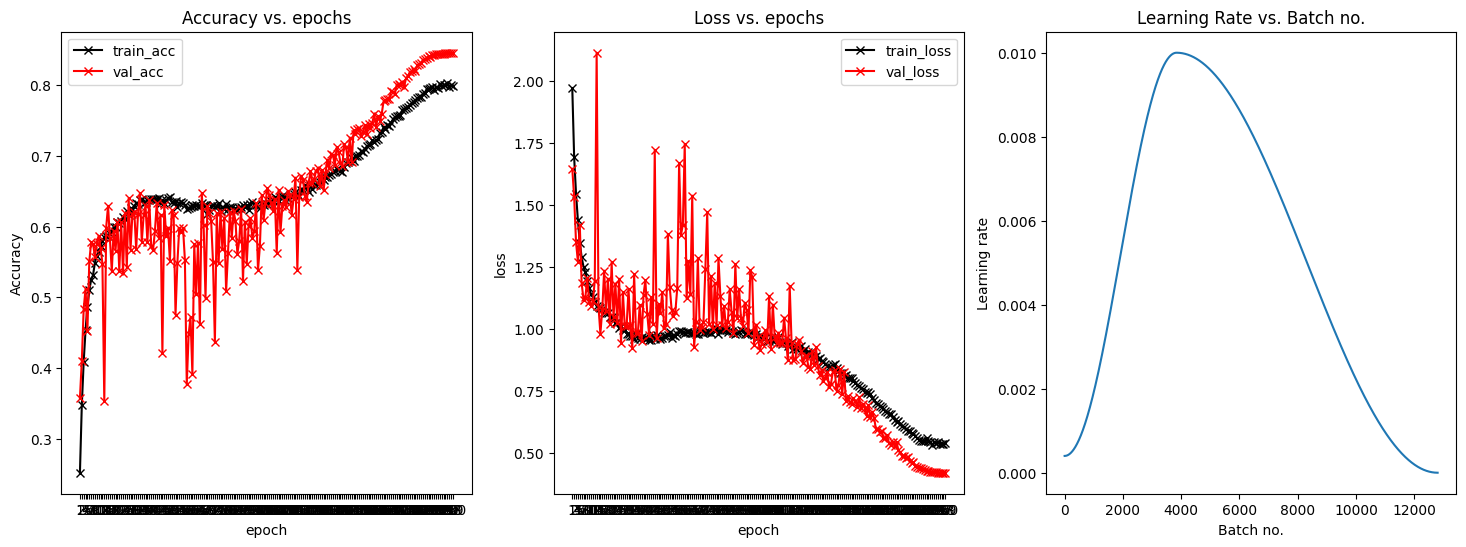

In [39]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_accuracies(history)
plt.subplot(1, 3, 2)
plot_losses(history)

plt.subplot(1, 3, 3)
plot_lrs(history)